In [94]:
# Basic building-block packages
import numpy as np
from numpy import heaviside as th
import pandas as pd

# For numerical solutions of ODEs
from scipy.integrate import solve_ivp

# Some fancy-smancy maths!! (not really)
from scipy.optimize import curve_fit
from scipy.stats import linregress
from numpy.linalg import norm
import scipy.fftpack as fft

# For pretty-pretty graphs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes,mark_inset)

# Quality of life shit
from tqdm import tqdm
import pickle



def NIC(x,a,b,B):
    g = -a*x*(th(x+B,1)-th(x-B,1)) # Centre
    g += (b*x+(a+b)*B)*th(-x-B,1) # Lefterior
    g += (b*x-(a+b)*B)*th(x-B,1) # Righterior
    return g

def Chua(x,a1,b1,B1,a2,b2,B2):
    return NIC(x,a1,b1,B1)+NIC(x,a2,b2,B2)

def sys_DE(t,w,inte,exte,circ):
    """
    Defines Chua's equations

    Arguments:
        w :  vector of the state variables:
                  w = [x,y,z]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    x,y,z = w
    R,C1,C2,L,F,freq = circ
    dx = ((y-x)/R-Chua(x,*inte,*exte))/C1
    dy = ((x-y)/R+z)/C2
    dz = -y/L-(F*np.sin(2*np.pi*freq*t))/L
    return dx,dy,dz

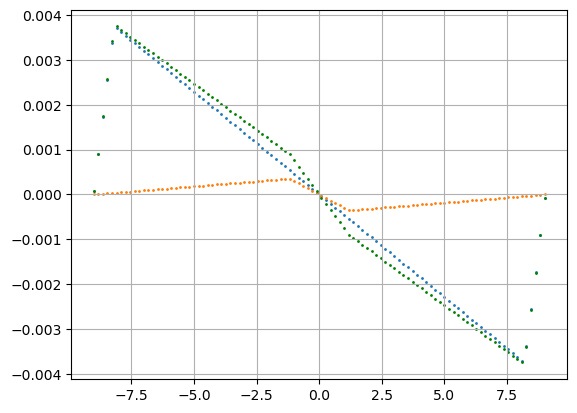

In [17]:
# Check Diode function

Vin = np.linspace(-9,9,100)
Y1 = [NIC(x,*interior) for x in Vin]
Y2 = [NIC(x,*exterior) for x in Vin]
Y0 = [Chua(x,*interior,*exterior) for x in Vin]

for Vout in [Y1,Y2]:
    plt.scatter(Vin,Vout
             ,s=1
             )

plt.scatter(Vin,Y0
            ,s=1
            ,color="green")
plt.grid()

## Integration method 2

by solve_ivp from scipy

In [49]:
# Numerical integration by solve_ivp

R = 2030
C1 = 10e-9
C2 = 100e-9
L = 25e-3

R2,R3 = 220,2200
R4,R6 = 22000,3300
A = 1000; E = 9

interior = [((A-1)*R2+R3)/(R2*(R2+(1+A)*R3))
            ,1/R2,
            (R2+(1+A)*R3)/(A*(R2+R3))*E]
exterior = [((A-1)*R4+R6)/(R4*(R4+(1+A)*R6))
            ,1/R4
            ,(R4+(1+A)*R6)/(A*(R4+R6))*E]

t_span = (0,.25)
t_eval = np.linspace(*t_span,int(1e7)) # No need to be so fine like here. 
xyz0 = [0.1,0.1,0.001] # Recall that z is in Amperes (a large unit).

Circ = [[R,C1,C2,L,0,0],[R,C1,C2,L,1,120],[R,C1,C2,L,0.9,570]]

data = {0: "NA",1:"NA",2:"NA"}

for i, circ in tqdm(enumerate(Circ)):
    solution = solve_ivp(sys_DE,t_span,xyz0,t_eval=t_eval,first_step=1e-7,
                        args=[interior,exterior,circ])
    data[i] = solution

0it [00:00, ?it/s]

3it [00:11,  3.82s/it]


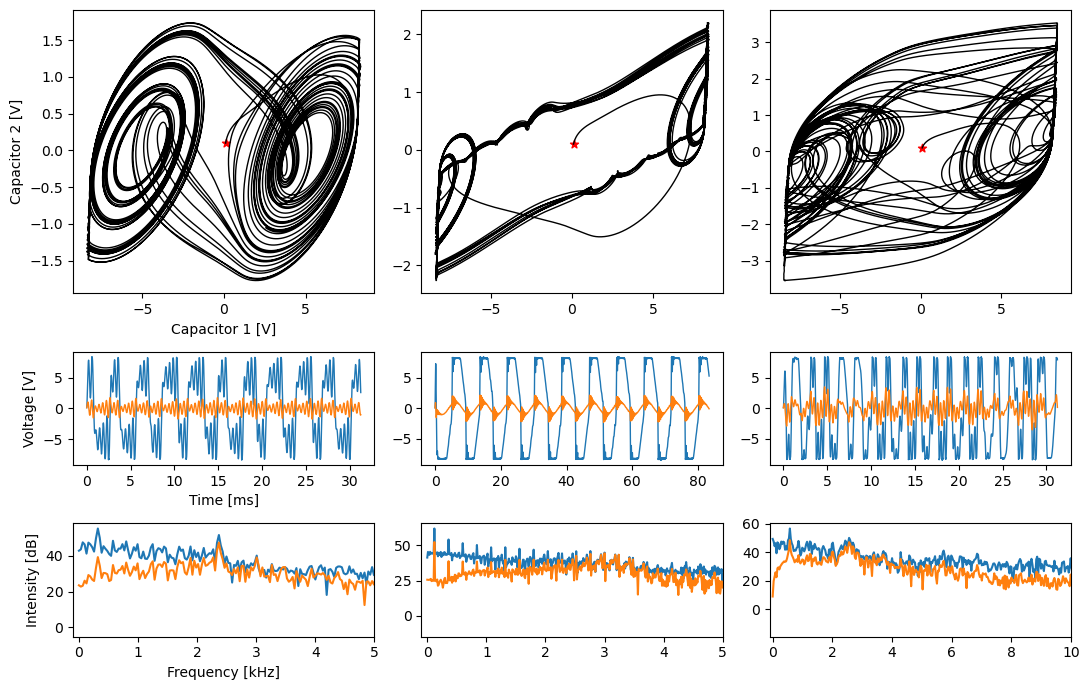

In [50]:
fig,axs = plt.subplots(3,3,figsize=(11,7)
                    #    ,sharey="row"
                       ,height_ratios=[2.5,1,1])
fig.subplots_adjust(wspace=0.05,hspace=0.33)

for i in range(3):
    
    solution = data[i]
    x_sol = solution.y[0]; y_sol = solution.y[1]
    time = solution.t

    if i==0:
        frc = int(len(time)/8); div = 10
    elif i==1:
        frc = int(len(time)/3); div = 10
    else:
        frc = int(len(time)/8); div = 10

    x_sol = x_sol[:frc:div]
    y_sol = y_sol[:frc:div]
    time = time[:frc:div]

    fourier = [np.abs(fft.fft(sol)) for sol in [x_sol,y_sol]] 
    fourier = [10*np.log10(fou) for fou in fourier]
        
    tau = time[1]-time[0] # time interval
    freq = fft.fftfreq(len(x_sol), tau)

    axs[0,i].plot(x_sol,y_sol
                ,linewidth=1,color="k"
                )
    axs[0,i].scatter(x_sol[0],y_sol[0]
                ,marker="*",color="r"
                )

    for var in [x_sol,y_sol]:
        axs[1,i].plot(time*1000, var,linewidth=1)

    for j in range(2): 
        axs[2,i].plot(freq[freq>=0]/1000, fourier[j][freq>=0])
    
    if i==0:
        axs[2,i].set_xlim(-.1,5)
    elif i==1:
        axs[2,i].set_xlim(-.1,5)
    else:
        axs[2,i].set_xlim(-.1,10)

axs[0,0].set_xlabel("Capacitor 1 [V]")
axs[0,0].set_ylabel("Capacitor 2 [V]")

axs[1,0].set_ylabel("Voltage [V]")
axs[1,0].set_xlabel("Time [ms]")

axs[2,0].set_ylabel("Intensity [dB]")
axs[2,0].set_xlabel("Frequency [kHz]")

plt.tight_layout()
plt.show()
plt.close("all")

# Measured samples

C:\Users\chwan\AppData\Local\Temp\ipykernel_25112\1086106774.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


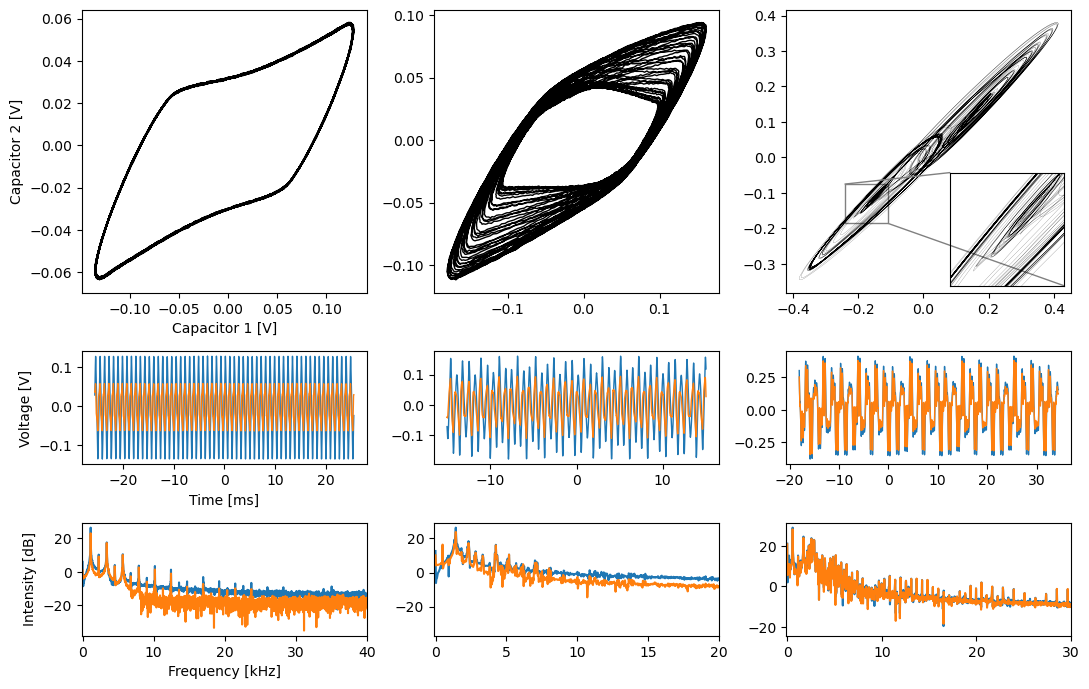

In [95]:
fig,axs = plt.subplots(3,3,figsize=(11,7)
                    #    ,sharey="row"
                       ,height_ratios=[2.5,1,1])
fig.subplots_adjust(wspace=0.05,hspace=0.33)

path = ["periodic","quasi","chaos"]

for i in range(3):
    directory = f"collected_data/{path[i]}.csv"
    data = pd.read_csv(directory)#,skiprows=31)
    
    time = data['Time (s)'].values
    x_sol = data['Channel 1 (V)'].values
    y_sol = data['Channel 2 (V)'].values


    dt = time[1]-time[0]

    if i==0:
        frc = int(len(time)/1); div = 1
    elif i==1:
        frc = int(len(time)/1); div = 1
    else:
        frc = int(len(time)/1); div = 1

    x_sol = x_sol[:frc:div]
    y_sol = y_sol[:frc:div]
    time = time[:frc:div]

    fourier = [np.abs(fft.fft(sol)) for sol in [x_sol,y_sol]] 
    fourier = [10*np.log10(fou) for fou in fourier]
        
    tau = time[1]-time[0] # time interval
    freq = fft.fftfreq(len(x_sol), tau)

    for var in [x_sol,y_sol]:
        axs[1,i].plot(time*1000, var,linewidth=1)

    for j in range(2): 
        axs[2,i].plot(freq[freq>=0]/1000, fourier[j][freq>=0])
    
    if i==0:
        axs[2,i].set_xlim(-.1,40)
        axs[0,i].plot(x_sol,y_sol
                ,linewidth=1,color="k"
                )
    elif i==1:
        axs[2,i].set_xlim(-.1,20)
        axs[0,i].plot(x_sol,y_sol
                ,linewidth=1,color="k"
                )
    else:
        axs[2,i].set_xlim(-.1,30)
        axs[0,i].plot(x_sol,y_sol
                ,linewidth=.1,color="k"
                )

        x_zoom = x_sol[50:60]; y_zoom = y_sol[47:57]

        # Create an inset subplot within the main plot
        axin1 = inset_axes(axs[0,i], width="40%", height="40%", loc='lower right')
        axin1.plot(x_sol, y_sol,linewidth=.1, color='black')

        # Set limits for the inset plot
        axin1.set_xlim(min(x_zoom), max(x_zoom))
        axin1.set_ylim(min(y_zoom), max(y_zoom))
        axin1.set_xticks([])
        axin1.set_yticks([])
        
        mark_inset(axs[0,i], axin1, loc1=2, loc2=4, fc="none", ec='0.5')

    # axs[0,i].scatter(x_sol[0],y_sol[0]
    #             ,marker="*",color="r"
    #             )

axs[0,0].set_xlabel("Capacitor 1 [V]")
axs[0,0].set_ylabel("Capacitor 2 [V]")

axs[1,0].set_ylabel("Voltage [V]")
axs[1,0].set_xlabel("Time [ms]")

axs[2,0].set_ylabel("Intensity [dB]")
axs[2,0].set_xlabel("Frequency [kHz]")

plt.tight_layout()
plt.show()
plt.close("all")

# Bifurcation plot

In [8]:
handle = open(f"collected_data/chua_varamp.pkl", 'rb') # Fixed freq
# handle = open(f"collected_data/chua_varfreq.pkl", 'rb') # Fixed amp
data = pickle.load(handle)
handle.close()

amp = np.array(list(data.keys()))
len(amp)

500

In [9]:
# Save the plot points coordinates and plot the with a single call to plt.plot
# instead of plotting them one at a time, as it's much more efficient
r1,r2 = [],[]
x_max,y_max = [],[]

# for F in tqdm(amp[amp<=0.3]):
for F in tqdm(amp):
    _,x,y = data[F]
    # Find local extrema of x
    for i in range(1,len(x)-1):
        # Find the local maxima
        if x[i - 1] < x[i] and x[i] > x[i + 1]:
            r1.append(F)
            x_max.append(x[i])
        if y[i - 1] < y[i] and y[i] > y[i + 1]:
            r2.append(F)
            y_max.append(y[i])
r1,r2 = np.array(r1),np.array(r2)
x_max,y_max = np.array(x_max),np.array(y_max)

100%|██████████| 500/500 [00:02<00:00, 201.00it/s]


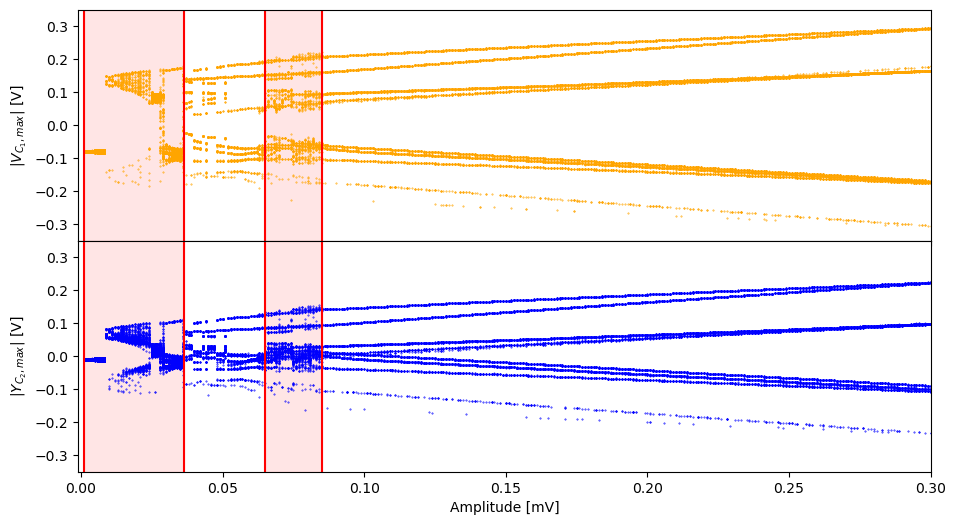

In [10]:
# Amplitude bifurcation

fig,axs = plt.subplots(2,1,figsize=(11,6)
                       ,sharex=True,sharey=True
                       ,height_ratios=[1,1])
fig.subplots_adjust(wspace=0.05,hspace=0.)

axs[0].set_ylabel(r"$|V_{C_1, max}|$ [V]")
axs[1].set_ylabel(r"$|Y_{C_2,max}|$ [V]")

axs[1].set_xlabel("Amplitude [mV]")

axs[0].set_xlim(-0.001,0.3)
axs[0].set_ylim(-0.35,0.35)

for i in range(2):
    axs[i].vlines(x=0.001,ymin=-.5,ymax=.5,color="red")
    axs[i].vlines(x=0.03623,ymin=-.5,ymax=.5,color="red")
    axs[i].fill_betweenx(axs[i].get_ylim(), 0.001, 0.03623, color='red', alpha=0.1)

    
    axs[i].vlines(x=0.065,ymin=-.5,ymax=.5,color="red")
    axs[i].vlines(x=0.085,ymin=-.5,ymax=.5,color="red")
    axs[i].fill_betweenx(axs[i].get_ylim(), 0.065, 0.085, color='red', alpha=0.1)

axs[0].scatter(r1, x_max, color="orange", s=0.15)
axs[1].scatter(r2, y_max, color="blue", s=0.15)

# axs[1].set_xlabel("Frequency [Hz]")
# axs[1].set_yticks([0.00,0.05,0.10,0.15,0.20])

plt.show()
plt.close("all")

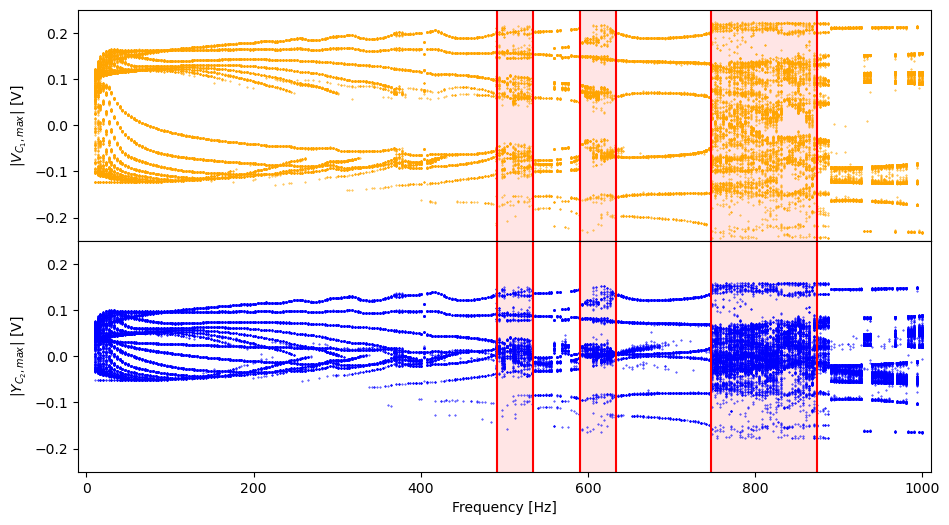

In [7]:
# Frequency bifurcation

fig,axs = plt.subplots(2,1,figsize=(11,6)
                       ,sharex=True,sharey=True
                       ,height_ratios=[1,1])
fig.subplots_adjust(wspace=0.05,hspace=0.)

axs[0].set_ylabel(r"$|V_{C_1, max}|$ [V]")
axs[1].set_ylabel(r"$|Y_{C_2,max}|$ [V]")

axs[1].set_xlabel("Frequency [Hz]")

axs[0].set_ylim(-0.25,0.25)
axs[0].set_xlim(-10,1010)

for i in range(2):
    axs[i].vlines(x=491,ymin=-.5,ymax=.5,color="red")
    axs[i].vlines(x=534,ymin=-.5,ymax=.5,color="red")
    axs[i].fill_betweenx(axs[i].get_ylim(), 491, 534, color='red', alpha=0.1)

    axs[i].vlines(x=591,ymin=-.5,ymax=.5,color="red")
    axs[i].vlines(x=634,ymin=-.5,ymax=.5,color="red")
    axs[i].fill_betweenx(axs[i].get_ylim(), 591, 634, color='red', alpha=0.1)

    axs[i].vlines(x=747,ymin=-.5,ymax=.5,color="red")
    axs[i].vlines(x=874,ymin=-.5,ymax=.5,color="red")
    axs[i].fill_betweenx(axs[i].get_ylim(), 747, 874, color='red', alpha=0.1)

axs[0].scatter(r1, x_max, color="orange", s=0.15)
axs[1].scatter(r2, y_max, color="blue", s=0.15)

plt.show()
plt.close("all")

## Lyapunov exponent

Retrieved from : https://arxiv.org/pdf/physics/0303077.pdf

Given two independent trajectories $X_1(t)$ and $X_2(t)$ of distinct
initial contiditions, $X_1(t_0)=X_0$, $X_2(t_0)=X_0+\delta X_0$, we can define the largest 
Lyapunov exponent as 

$||\delta X||=e^{\lambda_{max}t}||\delta X_0||$

where $||\cdot||$ is any definite norm.

# Lyapunov exponent from Rosenstein et al.

https://www.math.lsu.edu/clinic/4020clinic/GaitSP08/files/Rosenstein%20Lyapunov%20exponent.pdf

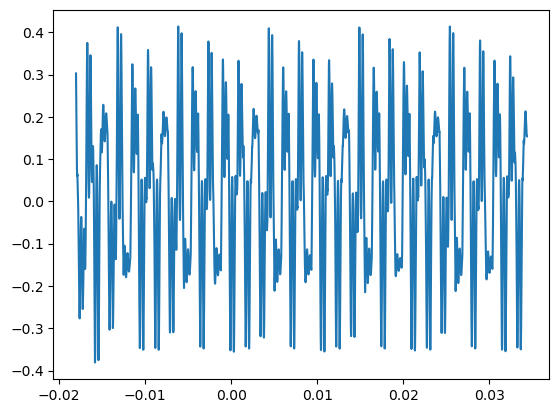

In [75]:
import pandas as pd

path = "collected_data/chaos.csv"

data = pd.read_csv(path,skiprows=31)

F = 0.9
f = 570

time = data['Time (s)'].values
x = data['Channel 1 (V)']

dt = time[1]-time[0]

plt.plot(time,x)

In [14]:
handle = open("collected_data\chua_varfreq.pkl", 'rb')
data=pickle.load(handle)
handle.close()

param = np.array(list(data.keys()))
data[param[1]]

3

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

9.923400750085073e-14


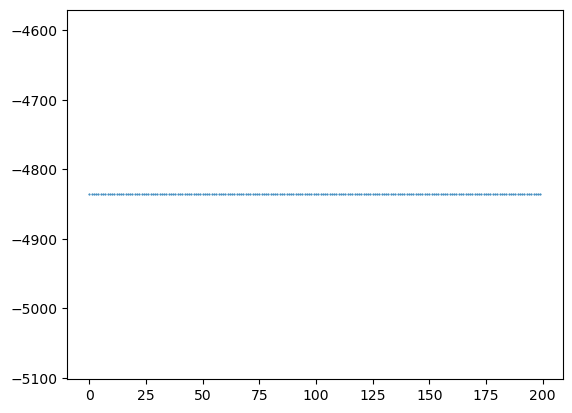

In [32]:
import statsmodels.api as sm
from scipy.spatial.distance import cdist

for p in tqdm(param[:1]):
    x,_,t = data[p]

    frac = 10
    dt = t[1]-t[0]
    # int(len(x_sol)/10)
    x = x[::frac]
    t = t[::frac]

    n = 3; 
    m = 9 # >2n
    N = len(t)

    # Find reconstruction delay. 
    autocor = sm.tsa.acf(x)
    J = np.argmin(autocor[autocor/autocor[0] > 1-1/np.e])
    M = N-(m-1)*J

    # Find reconstructed trajectory matrix
    X = np.array([x[i:i+(m-1)*J+1] for i in range(M)])
    T = np.array([t[i:i+(m-1)*J+1] for i in range(M)])

    # Find mean frequency.
    magnitude_spectrum = np.abs(np.fft.fft(X))
    f_domn = np.argmax(magnitude_spectrum)/N
    f_mean = f_domn/dt

    # Find time constraint. 
    msk = cdist(T,T, metric='euclidean') > 1/f_mean
    msk = np.where(msk)

    # Exclude all Xj,X\hat{j} by time constraint.
    norm_pair = cdist(X,X, metric='euclidean')

    d0 = np.full(norm_pair.shape, np.nan)
    d0[msk] = norm_pair[msk]

    # Find index j of nearest neighbor.
    closest = np.nanargmin(d0,axis=0)
    
    di =[]
    for i in range(M):
        dj = [norm(X[j]-X[closest[j]]) for j in range(M-i)]
        dj = np.log(np.mean(dj))/dt
        di.append(dj)
    di = np.array(di)

    Di = di[:200]
    print(np.std(di))
    plt.plot(range(len(Di)),Di,'o',markersize=0.5,label=p)
# plt.legend(loc="lower right")

In [21]:

range(len(di))*dt

array([0.        , 0.00442152, 0.00884304, 0.01326456, 0.01768609,
       0.02210761, 0.02652913, 0.03095065, 0.03537217, 0.03979369,
       0.04421521, 0.04863674, 0.05305826, 0.05747978, 0.0619013 ,
       0.06632282, 0.07074434, 0.07516586, 0.07958739, 0.08400891,
       0.08843043, 0.09285195, 0.09727347, 0.10169499, 0.10611651,
       0.11053804, 0.11495956, 0.11938108, 0.1238026 , 0.12822412,
       0.13264564, 0.13706717, 0.14148869, 0.14591021, 0.15033173,
       0.15475325, 0.15917477, 0.16359629, 0.16801782, 0.17243934,
       0.17686086, 0.18128238, 0.1857039 , 0.19012542, 0.19454694,
       0.19896847, 0.20338999, 0.20781151, 0.21223303, 0.21665455,
       0.22107607, 0.22549759, 0.22991912, 0.23434064, 0.23876216,
       0.24318368, 0.2476052 , 0.25202672, 0.25644824, 0.26086977,
       0.26529129, 0.26971281, 0.27413433, 0.27855585, 0.28297737,
       0.28739889, 0.29182042, 0.29624194, 0.30066346, 0.30508498,
       0.3095065 , 0.31392802, 0.31834954, 0.32277107, 0.32719

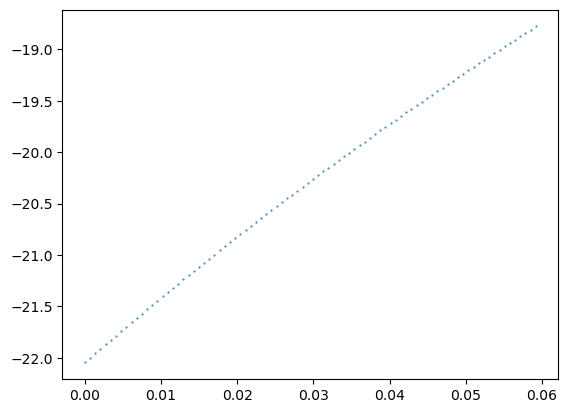

In [347]:
# Remove initial exponential region

delta = di[1:]-di[:-1]
delta = np.insert(delta,0,0)
Di = di[500:]
# len(indices)

plt.plot(range(len(Di))*dt,Di,'o',markersize=0.5)